In [10]:
import pandas as pd
import numpy as np
import copy
import random
import cv2
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from dataset.all_datasets import Camelyon17
from sklearn.model_selection import train_test_split

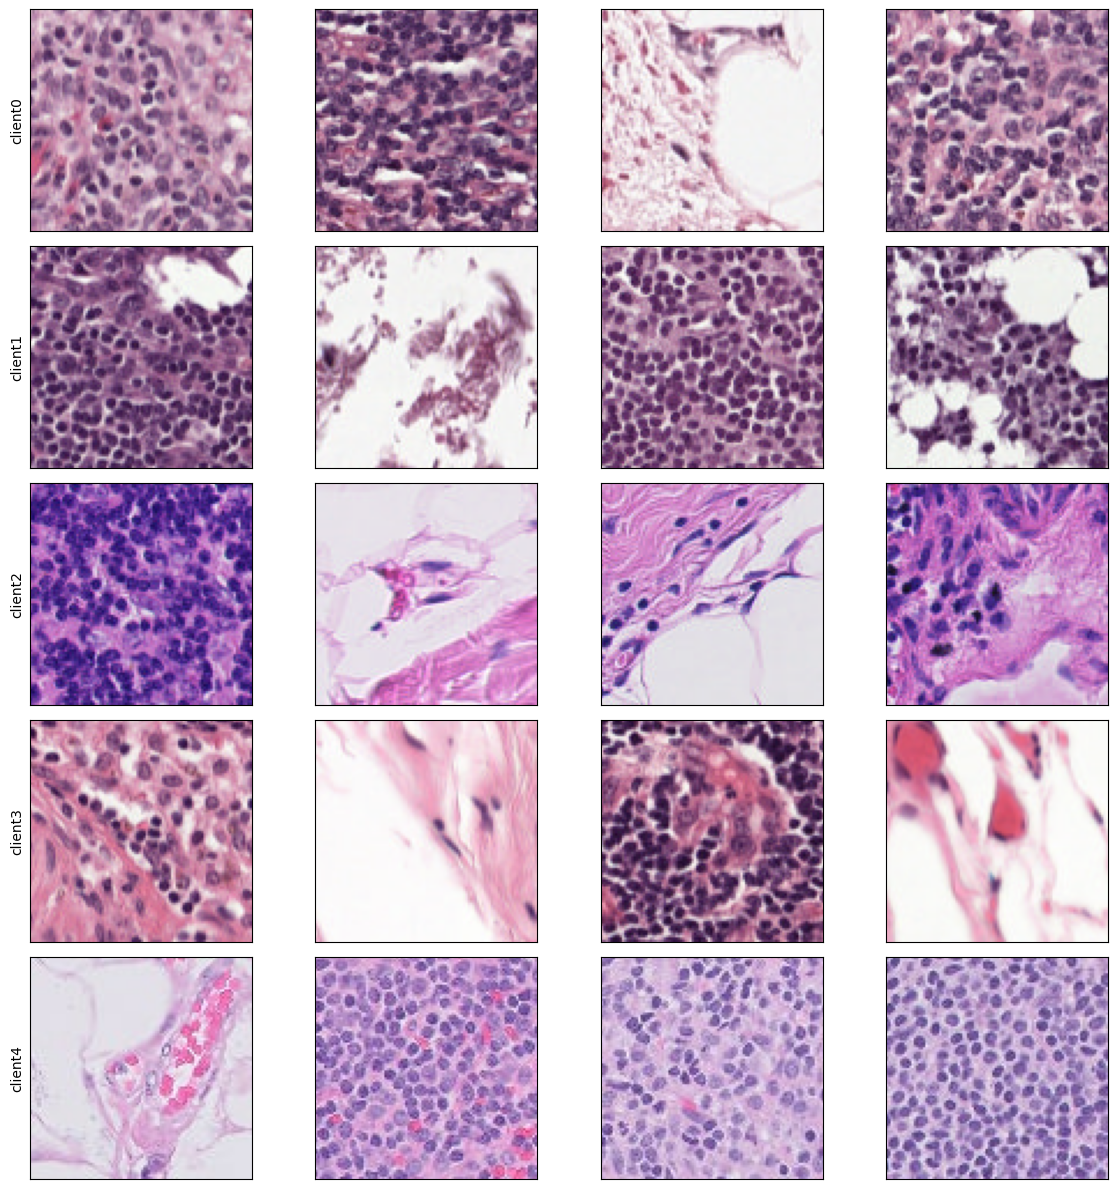

In [11]:
train_df = pd.read_csv('/home/xkx/Camelyon17/train.csv')
data_dir = '/home/xkx/Camelyon17/'

import matplotlib.pyplot as plt
from PIL import Image

# 创建一个图像列表
image_list = []
indices = [0, 200, 1000, 2000, 10000, 10200, 11000, 12000, 
           20000, 20200, 21000, 22000, 30000, 30200, 31000, 32000,
           40000, 40200, 41000, 42000]

# 遍历索引并加载图像到列表中
for i in range(20):
    img = Image.open(data_dir + train_df['id'][indices[i]])
    image_list.append(img)

# 绘制图像
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(image_list[i])
    plt.xticks([])
    plt.yticks([])  # 隐藏刻度
    if i % 4 == 0:
        plt.ylabel(f'client{i//4}')
plt.tight_layout()  # 调整子图之间的间距
plt.savefig('/home/xkx/pro/FedNoRo/data/Camelyon17/clients.png')
plt.show()




the client number is: 20


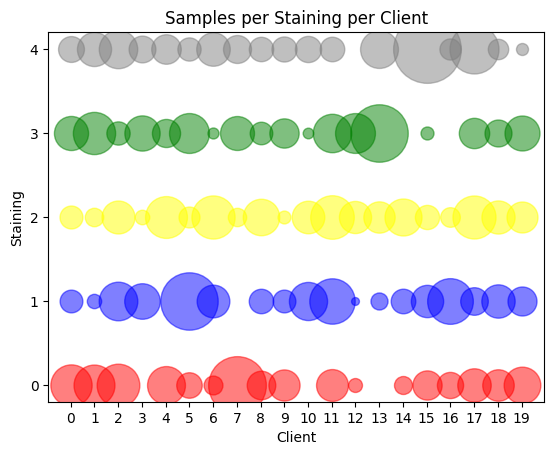

           Staining 0  Staining 1  Staining 2  Staining 3  Staining 4
Client 0          883         268         273         603         347
Client 1          868         107         177         925         604
Client 2          944         774         564         281         766
Client 3            0         655         110         644         372
Client 4          744           0         908         410         452
Client 5          337        1708         228         826         280
Client 6          185         555         966          63         583
Client 7         1726           0         175         598         405
Client 8          423         311         691         264         309
Client 9          503         269          86         445         326
Client 10           0         755         551          59         356
Client 11         527        1069         984         767         313
Client 12         101          32         536         824           0
Client 13           

In [28]:
# Strucutre of .npy file

dict_users = np.load('/home/xkx/Camelyon17/train_dict_user.npy', allow_pickle=True).item()

print('the client number is: ' + str(len(dict_users)))
# show the ids of the first client
# print('the ids of the first client are: ' + str(train_dict[0]))

# 遍历每个键及对应的值(列表),打印列表长度
keys = list(dict_users.keys())
for key in keys:
    value_list = dict_users[key]
    list_len = len(value_list)
    # print(f"Key: {key}, Length of value list: {list_len}")
    

# visualize the structure of the .npy file
stainings_per_client = {client: {i: 0 for i in range(0, 5)} for client in dict_users}

# 计算每个客户端上，不同staining的样本数量
for client, samples in dict_users.items():
    for sample_id in samples:
        staining = (sample_id // 10000)
        stainings_per_client[client][staining] += 1
        
colors = ['red', 'blue', 'yellow', 'green', 'gray']

# 绘制气泡图
for client in stainings_per_client:
    for staining, count in stainings_per_client[client].items():
        plt.scatter(client, staining, s=count, alpha=0.5, c=colors[staining])


plt.xticks(range(20))
plt.yticks(range(5))
plt.xlabel('Client')
plt.ylabel('Staining')
plt.title('Samples per Staining per Client')
plt.savefig('/home/xkx/pro/FedNoRo/data/Camelyon17/client_staining_scatter.png')
plt.show()

cols = [f'Staining {i}' for i in range(5)]
rows = [f'Client {i}' for i in range(20)]
data = [[stainings_per_client[client][staining] for staining in range(5)] for client in range(20)]
df = pd.DataFrame(data, columns=cols, index=rows)
print(df)
df.to_csv('/home/xkx/pro/FedNoRo/data/Camelyon17/client_staining_scatter.csv')



In [5]:
# Class to One-Hot Encoding

# 读取CSV文件
df = pd.read_csv('/home/xkx/Camelyon17/test.csv')

# 将'class'列转换为独热编码形式
one_hot = pd.get_dummies(df['class'], prefix='class').astype(int)

# 统计class_0和class_1的数量
class_0_count = one_hot['class_0'].sum()
class_1_count = one_hot['class_1'].sum()

# 打印结果
print(f"Class 0 的数量为: {class_0_count}")
print(f"Class 1 的数量为: {class_1_count}")

# 将独热编码的DataFrame连接回原始DataFrame
df = df.join(one_hot)

# 删除原始的'class'列
df.drop('class', axis=1, inplace=True)

# 查看结果
print(df.head())

# 保存结果
# df.to_csv('/home/xkx/Camelyon17/test_onehot.csv', index=False)

Class 0 的数量为: 5000
Class 1 的数量为: 5000
                                                  id  class_0  class_1
0  patches/patient_017_node_1/patch_patient_017_n...        1        0
1  patches/patient_004_node_4/patch_patient_004_n...        1        0
2  patches/patient_017_node_2/patch_patient_017_n...        1        0
3  patches/patient_017_node_2/patch_patient_017_n...        1        0
4  patches/patient_016_node_1/patch_patient_016_n...        1        0


In [6]:
# Add Staining Column

df = pd.read_csv('/home/xkx/Camelyon17/train.csv')
df['staining'] = df.index // 10000
print(df.head())
df.to_csv('/home/xkx/Camelyon17/train_staining.csv', index=False)

df = pd.read_csv('/home/xkx/Camelyon17/test.csv')
df['staining'] = df.index // 2000
print(df.head())
df.to_csv('/home/xkx/Camelyon17/test_staining.csv', index=False)

                                                  id  class  staining
0  patches/patient_017_node_4/patch_patient_017_n...      0         0
1  patches/patient_010_node_4/patch_patient_010_n...      0         0
2  patches/patient_017_node_2/patch_patient_017_n...      0         0
3  patches/patient_012_node_0/patch_patient_012_n...      0         0
4  patches/patient_004_node_4/patch_patient_004_n...      0         0
                                                  id  class  staining
0  patches/patient_017_node_1/patch_patient_017_n...      0         0
1  patches/patient_004_node_4/patch_patient_004_n...      0         0
2  patches/patient_017_node_2/patch_patient_017_n...      0         0
3  patches/patient_017_node_2/patch_patient_017_n...      0         0
4  patches/patient_016_node_1/patch_patient_016_n...      0         0


In [10]:
# add attribute related noise
np.random.seed(0)
# 储存不同staining对应的噪声率
staining_noise_rate = [0.4, 0.4, 0.3, 0.2, 0.1]
noise_ratio = 0.4
num_users = 3
y_train = np.array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0])
y_staining = np.array([0, 4, 1, 2, 3, 0, 0, 1, 3, 1, 2, 2])
dict_users = {0: [0, 1, 2, 3, 4, 5], 1: [6, 7, 8, 9, 10], 2: [11]}

# noisy_indices = np.random.choice(a=num_users, size=int(noise_ratio * num_users), replace=False)

gamma_s = np.array([0.] * num_users)
gamma_s[:int(noise_ratio * num_users)] = 1.
np.random.shuffle(gamma_s)

# 噪声标签
y_train_noisy = copy.deepcopy(y_train)
real_noise_level = [0] * num_users

# 为每个样本应用噪声
for idx in np.where(gamma_s > 0)[0]:
    # 获取该用户的所有样本的staining值
    user_staining = y_staining[dict_users[idx]]
    # 获取该用户的样本索引
    user_samples_idx = dict_users[idx]
    # 对每一个staining类别的样本单独处理
    for stain,_ in enumerate(staining_noise_rate):
        stain_indices = np.where(user_staining == stain)[0]
        num_noisy_samples = int(staining_noise_rate[stain] * len(stain_indices))
        # 随机选择样本添加噪声
        noisy_samples = np.random.choice(stain_indices, num_noisy_samples, replace=False)
        for sample in noisy_samples:
            # 添加噪声，这里简单假设为标签翻转（您可以替换为其他噪声模型）
            y_train_noisy[user_samples_idx[sample]] = 1 - y_train[user_samples_idx[sample]]

    # 计算实际噪声水平
    noise_ratio = np.mean(y_train[user_samples_idx] != y_train_noisy[user_samples_idx])
    real_noise_level[idx] = noise_ratio
    print(f"Client {idx}, Real noise ratio: {real_noise_level[idx]:.4f}")

# 计算所有客户端的平均噪声水平
avg_real_noise_level = np.mean(real_noise_level)
print(f"Average real noise ratio across all clients: {avg_real_noise_level:.4f}")

print(f'y_train_noisy: {y_train_noisy}')
print(f'gamma_s: {gamma_s}')
print(f'real_noise_level: {real_noise_level}')


Client 2, Real noise ratio: 0.0000
Average real noise ratio across all clients: 0.0000
y_train_noisy: [0 0 1 1 0 1 0 1 1 0 0 0]
gamma_s: [0. 0. 1.]
real_noise_level: [0, 0, 0.0]


In [17]:
# Devided the dataset by patients
random.seed(0)

# 加载数据集
train_df = pd.read_csv('~/Camelyon17/train.csv')
test_df = pd.read_csv('~/Camelyon17/test.csv')

all_data = pd.concat([train_df, test_df])


# 提取病人ID，假设每个图像的ID格式是: 'patches/patient_XXX_node_...'
all_data['patient_id'] = all_data['id'].str.extract(r'patient_([0-9]+)_node')

#                                                   id  class patient_id
# 0  patches/patient_017_node_4/patch_patient_017_n...      0        017
# 1  patches/patient_010_node_4/patch_patient_010_n...      0        010

# 对病人ID去重
unique_patients = all_data['patient_id'].unique()

# 每个病人有多少个样本
patient_sample_counts = all_data['patient_id'].value_counts()
patient_sample_counts_shuffled = patient_sample_counts.copy()
random.shuffle(patient_sample_counts_shuffled)
print(patient_sample_counts_shuffled)



# 按病人ID划分数据为新的训练集和测试集 (保持1/6用于测试集)
train_patients, test_patients = train_test_split(unique_patients, test_size=1/6, random_state=0) # random_seed=0

print(f"训练集病人数量: {len(train_patients)}")
print(f"测试集病人数量: {len(test_patients)}")


# 
# # 分配病人至训练集或测试集
# train_data = all_data[all_data['patient_id'].isin(train_patients)]
# test_data = all_data[all_data['patient_id'].isin(test_patients)]
# 
# # 确保新的划分保持类别平衡性
# train_class_dist = train_data['class'].value_counts(normalize=True)
# test_class_dist = test_data['class'].value_counts(normalize=True)
# 
# print(f"训练集类别分布:\n{train_class_dist}")
# print(f"测试集类别分布:\n{test_class_dist}")
# 
# # 保存新的划分结果到CSV
# train_data.to_csv('~/Camelyon17/new_train.csv', index=False)
# test_data.to_csv('~/Camelyon17/new_test.csv', index=False)

patient_id
073     427
096    1401
051     398
017    5327
022     897
012     954
020    1182
015    2175
052     966
075     949
034    1315
099    2553
086    2762
024    5006
092     704
046    1161
045    1685
060     390
081     752
068     543
042     657
039     380
036     570
009     998
004     493
010     497
062     510
044    3750
016     322
048    3582
087    1756
080    1773
021    1306
067     921
040     629
088     966
041     821
072     593
038     577
089    1111
064    4552
066     798
061     891
Name: count, dtype: int64
训练集病人数量: 35
测试集病人数量: 8


/home/xkx/anaconda3/envs/venv/lib/python3.9/random.py:362: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x[i], x[j] = x[j], x[i]
/home/xkx/anaconda3/envs/venv/lib/python3.9/random.py:362: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  x[i], x[j] = x[j], x[i]
